In [32]:
# basic function to pull out all variables saved from matlab as dictionaries. Ignores the metadata also pulled in
# with loadmat

def import_matlab_file(file):
    from scipy.io import loadmat
    
    mat_data = loadmat(file, struct_as_record = False, squeeze_me = True, mat_dtype = True, chars_as_strings = True, simplify_cells = True)
    mat_data =  {k:v for k,v in mat_data.items() if '__' not in k};
    
    return mat_data
    

In [2]:
def pd_from_uneven_dict_old(d):

    import pandas as pd
    shapes = [v.shape for v in d.values()]
    single_dim = {k:v for k,v in d.items() if max(shapes)[0] == v.shape[0]}
    d2 = {};
    for k,v in d.items():
        if len(v.shape) > 1:
            for i, j in enumerate(v):
                key_name = k + "_" + f'{i}'
                single_dim[key_name] = j
        
        if (len(v.shape) == 1) & (v.shape[0] != max(shapes[0])):
            d2[k] = v


    df = pd.DataFrame(single_dim)
    return df, d2


In [33]:
# function to create a pd dataframe from a dictionary where MOST variables have one long dimension, in my case, 
# corresponding to the number of trials. It tries to make keys the columns and the rows the trials. For cases
# where there is 2D data, if there are greater than 10 elements in the second dim, it makes a list so each row 
# contains an array, if not it splits those into seperate columns with the convention k + idx as column name. 
# 3D data is split in third dimension then treated as a large ( >10 ) size.
def pd_from_uneven_dict(d):

    import numpy as np
    import pandas as pd
    
    shapes = [v.shape for v in d.values() if len(v.shape) == 1]
    trials = max(shapes)[0]

    single_dim = {k:v for k,v in d.items() if (len(v.shape) == 1)  & (trials == v.shape[0])};
    df = pd.DataFrame(single_dim);

    remainder = {};

    for k,v in d.items():
        
        if len(v.shape)  ==  3:
            split_data = np.dsplit(v, v.shape[2]);
            for ind, dim in enumerate(split_data):
                col_name = k + "_"+f'{ind}';
                if dim.shape[0] == trials:
                    df[col_name] = list(np.squeeze(dim))
                else:
                    df[col_name] = list(np.squeeze(dim.transpose))
        elif len(v.shape) == 2:
            if v.shape[1] == trials:
                v = v.transpose()

            if v.shape[1] < 10:
                for i, j in enumerate(v.transpose()):
                        col_name = k + "_" + f'{i}'
                        
                        df[col_name] = j
            else:
                col_name = k
                df[col_name] = list(np.squeeze(v))
                
        elif (len(v.shape) == 1)  & (trials != v.shape[0]):
            remainder[k] = v;

        
            
    return df, remainder


In [34]:
def determine_latency(rxn, c):
    import numpy as np
    rx = []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))

        if r.size == 0 and rxn[a] > 0:
            rx.append(rxn[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])

    return rx

In [57]:
# Function to take a folder path, load the behavioral and licking data. Clean it to a nice lil pandas df
def load_beh_data(path, animal_id):

    import os 
    import pandas as pd
    import numpy as np

    file_data = 'analyze_animal_'+animal_id+'.mat'
    data_path = os.path.join(path,file_data)

    beh_data = import_matlab_file(data_path)
    beh_df, ignore = pd_from_uneven_dict(beh_data['animal'])
    beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})

    boo_cols = ["RH", "LH", "RM", "LM", "NG", "LED"]
    beh_df[boo_cols] = beh_df[boo_cols].astype(bool)


    file_ttl = 'ttl_info_'+animal_id+'.mat'
    ttl_path = os.path.join(path, file_ttl)
    ttl_data = import_matlab_file(ttl_path)

    beh_df['Spout_1']= np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
    beh_df['Spout_2'] = np.mean(ttl_data['trial_info']['lick'][:,750:825,1],axis = 1)


    file_ttl2 = 'ttl_choices_'+animal_id+'.mat'
    ttl_path2 = os.path.join(path, file_ttl2)
    ttl_data2 = import_matlab_file(ttl_path2)
    c = ttl_data2['trial_info']['choice'][:,:,750:1750]
    beh_df['latency'] = determine_latency(beh_df['rxnTime'], c)

    return beh_df
    
    

In [58]:
def clean_beh_data(b):
    import numpy as np
    import pandas as pd

    
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['sessionNum'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['stimulus']/8)/2
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['target'].astype(int);
    b2['Session'] = b['sessionNum'];

   
    b2['Latency'] = b['latency']/1000;
    #b2['New_session']= ns;
   
    go = (b['RH'] | b['LM'] | b['RM'] | b['LH']).values
    
    b2 = b2.iloc[go,:]
    
    return b2

In [ ]:
def preprocess_psytrack():
    import numpy as np

    inputs = dict(stim = np.expand_dims(np.array(b2['Stimulus']), axis=1),
        LED = np.expand_dims(np.array(b2['Stimulus']).astype(int), axis=1),
        previous_correct =  np.expand_dims(np.array(b2['Previous_correct']).astype(int), axis=1),
        previous_choice =  np.expand_dims(np.array(b2['Previous_rightward']).astype(int), axis=1),
        latency = np.expand_dims (np.array(b2['Previous_rightward']).astype(int), axis=1)
    )   


    dat = dict(
            subject = animal,
            inputs = inputs,
            correct = np.array(b2['Correct']),
            answer = np.array(b2['Target']),
            y = np.array(b2['Rightward']),
            dayLength=np.array(b2.groupby(['Session']).size()),
        )

weights = {k: 1 for k in inputs}
weights['bias'] = 1

k = np.sum([weights[i] for i in weights.keys()])




In [50]:
test = load_beh_data(os.getcwd(), 'c_129')
test.head()

,runID,stimulus,rxnTime,sessionNum,LED,target,RH,LH,RM,LM,NG,Spout_1,Spout_2,latency
0,1.0,32.0,-1.0,1.0,False,0.0,False,False,False,False,False,0.000000,0.0,NaN
1,1.0,2.0,-1.0,1.0,False,0.0,False,False,False,False,False,0.000000,0.0,NaN
2,1.0,2.0,-1.0,1.0,False,0.0,False,False,False,False,False,0.000000,0.0,NaN
3,1.0,32.0,-1.0,1.0,False,0.0,False,False,False,False,False,0.386667,0.0,NaN
4,1.0,2.0,-1.0,1.0,False,0.0,False,False,False,False,False,0.000000,0.0,NaN


In [31]:
#file = r'ttl_info_c_129.mat'
file = r'analyze_animal_c_129.mat'
mat_data = import_matlab_file(file)
#data, d2 = pd_from_uneven_dict(mat_data['animal'])


AttributeError: 'tuple' object has no attribute 'rename'

In [112]:
sp1 = np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
sp1.shape


(7707,)

In [80]:
work_path = r'C:\Users\natet\Desktop\Experimental_Data';
home_path = os.getcwd();
animal = 'c_129'




In [18]:
beh_df, remainder = pd_from_uneven_dict(mat_data['animal'])

In [103]:
beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})
beh_df.columns

Index(['runID', 'stimulus', 'rxnTime', 'sessionNum', 'LED', 'target', 'RH',
       'LH', 'RM', 'LM', 'NG'],
      dtype='object')

In [14]:
boo_cols = ['RH', 'LH', 'RM', 'LM', 'NG', 'LED']
beh_df[boo_cols] = beh_df[boo_cols].astype(bool)

NameError: name 'beh_df' is not defined

In [6]:
file_ttl2 =  r'ttl_choices_c_129.mat'
ttl_data2 = import_matlab_file(file_ttl2)
    

In [7]:
c = ttl_data2['trial_info']['choice'][:,:,750:2750]

In [25]:
lat = determine_latency(beh_df['rxnTime'], c)

<AxesSubplot:>

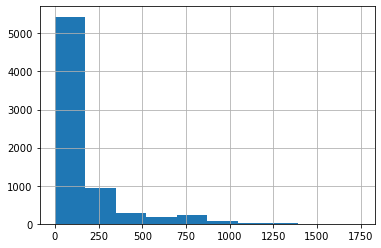

In [28]:
beh_df['latency'] = lat;
beh_df['latency'].hist()